In [ ]:
!nvidia-smi

Sat Apr  9 16:58:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#install python libraries
!pip install pandas
!pip install tqdm
!pip install wandb
!pip install simpletransformers

In [ ]:
from simpletransformers.classification import ClassificationArgs, ClassificationModel
import os
import sklearn
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from google.colab import files
import logging
from statistics import mean
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import re
import nltk

import wandb

# Data collection

In [ ]:
previous_train = pd.read_csv("/content/drive/Shareddrives/FYP17-TamilGrammer/DataCollection/NewsData/ArmyTamil/train.tsv", 
                       delimiter='\t', 
                       header=None, 
                       names=['text', 'label'])

In [ ]:
train_news_first = pd.read_csv("/content/drive/Shareddrives/FYP17-TamilGrammer/DataCollection/NewsData/NewsFirstTamil/train_newssfirst.tsv", 
                       delimiter='\t', 
                       header=None, 
                       names=['grammar text','error text', 'label'])

In [ ]:
train_news_first = train_news_first[["error text",'label']]

In [ ]:
train_news_first['label'].value_counts()

person    3703
number    1096
gender     564
Name: label, dtype: int64

In [ ]:
train_grammar_news_first = pd.read_csv("/content/drive/Shareddrives/FYP17-TamilGrammer/DataCollection/NewsData/NewsFirstTamil/grammatical_sentence.tsv", 
                       delimiter='\t', 
                       header=None, 
                       names=['grammar text', 'label'])

In [ ]:
train_df = pd.concat([previous_train,train_news_first,train_grammar_news_first])

In [ ]:
train_df['label'].value_counts()

grammatical    9998
person         9944
number         6984
gender         5525
Name: label, dtype: int64

In [ ]:
# class count
#class_count_person,class_count_number,class_count_gender,class_count_grammatical   =  train_df['label'].value_counts()
count_1,count_2,count_3,count_4 = train_df['label'].value_counts()
# class_count_grammatical =500
#under=3500
# Separate class
class_gender = train_df[train_df['label'] == 'gender']
class_number = train_df[train_df['label'] == 'number']
class_person = train_df[train_df['label'] == 'person']
class_grammatical = train_df[train_df['label'] == 'grammatical']
#class_1 = data[data['Class'] == 1]# print the shape of the class
print('class gender:', class_gender.shape)
print('class number:', class_number.shape)
print('class person:', class_person.shape)
print('class grammatical:', class_grammatical.shape)


class gender: (5525, 4)
class number: (6984, 4)
class person: (9944, 4)
class grammatical: (9998, 4)


In [ ]:
# class_gender_under = class_gender.sample(class_count_grammatical,random_state=4)
# class_number_under = class_number.sample(class_count_grammatical,random_state=4)
# class_person_under = class_person.sample(class_count_grammatical,random_state=4)
#class_grammatical_under = class_grammatical.sample(under,random_state=4)
class_number_over = class_number.sample(count_1,random_state=4,replace=True)
class_gender_over = class_gender.sample(count_1,random_state=4,replace=True)
class_person_over = class_person.sample(count_1,random_state=4,replace=True)

In [ ]:
#train_under = pd.concat([class_grammatical,class_number_under,class_person_under, class_gender_under], axis=0)
train_over = pd.concat([class_person_over,class_number_over, class_gender_over,class_grammatical], axis=0)

In [ ]:
#train_under['label'].value_counts()
train_over['label'].value_counts()

person         9998
number         9998
gender         9998
grammatical    9998
Name: label, dtype: int64

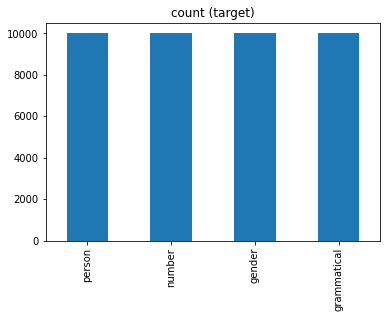

In [ ]:
#train_under['label'].value_counts().plot(kind='bar', title='count (target)')
train_over['label'].value_counts().plot(kind='bar', title='count (target)')


In [ ]:
#train_df, val_df = train_test_split(train_under, test_size=0.1, random_state=4,stratify=train_under["label"])
train_df, val_df = train_test_split(train_over, test_size=0.1, random_state=4,stratify=train_over["label"])

In [ ]:
eval_df, test_df = train_test_split(val_df, test_size=0.5, random_state=4,stratify=val_df["label"])

In [ ]:
print(f"No. of training examples: {train_df.shape[0]}")
print(f"No. of validation examples: {eval_df.shape[0]}")

No. of training examples: 35992
No. of validation examples: 2000


In [ ]:
train_df['label'].value_counts()

number         8998
grammatical    8998
person         8998
gender         8998
Name: label, dtype: int64

In [ ]:
eval_df['label'].value_counts()

grammatical    500
number         500
person         500
gender         500
Name: label, dtype: int64

In [ ]:
test_df['label'].value_counts()

person         500
gender         500
grammatical    500
number         500
Name: label, dtype: int64

In [ ]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
#after sweeping
model_args = ClassificationArgs()
model_args.eval_batch_size = 8
model_args.evaluate_during_training = True
model_args.evaluate_during_training_silent = False
model_args.evaluate_during_training_steps = 1000
model_args.learning_rate = 3e-5
model_args.manual_seed = 4
model_args.max_seq_length = 128
model_args.multiprocessing_chunksize = 5000
model_args.no_cache = True
model_args.no_save = True
model_args.num_train_epochs = 10
model_args.overwrite_output_dir = True
model_args.reprocess_input_data = True
model_args.train_batch_size = 16
model_args.gradient_accumulation_steps = 2
model_args.train_custom_parameters_only = False
model_args.labels_list = ["grammatical", "number","person","gender"]
model_args.wandb_project = "Multiclass- Hyperparameter Optimization - IndicBERT-1"

 # Create a TransformerModel
model = ClassificationModel(
        "albert",
        "ai4bharat/indic-bert",
        use_cuda=True,
        args=model_args,
        num_labels=4
    )
# Train the model
model.train_model(
    train_df,
    eval_df=eval_df,
    accuracy=lambda truth, predictions: accuracy_score(
            truth, predictions),
)

model.eval_model(test_df, verbose=True)

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertForSequenceClassification: ['sop_classifier.classifier.bias', 'predictions.LayerNorm.bias', 'sop_classifier.classifier.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indi

Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/35992 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Running Epoch 0 of 10:   0%|          | 0/2250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/250 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/2250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
#to download model from colab to local machine
!zip -r /content/outputs.zip /content/outputs

In [ ]:
df_test = pd.read_csv("test.tsv", 
                      delimiter='\t', 
                      header=None, 
                      names=['text', 'label'])

In [ ]:
from sklearn.metrics import f1_score, accuracy_score


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/716 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.9590338320181349, 'accuracy': 0.9734265734265735, 'eval_loss': 0.0848556359608968, 'f1': 0.9692737430167597, 'acc': 0.9692737430167597}


In [ ]:
wrong_predictions

In [ ]:
#convert label to numbers 
def map_label_to_number(df):
  
  # df_test['label'].str.strip()
  label_dict_error_types = {
      'grammatical':'grammatical',
      'gender': 'gender',
      'person': 'person',
      'number': 'number',
      'gender ':'gender',
      'number ':'number', 
      'person ':'person',
      ' gender':'gender',}
 

  df['label'].str.strip()
  df.label = df.label.replace(label_dict_error_types)
  return df


In [ ]:
# in training set map labels to number and check label counts
train = map_label_to_number(df_train)
train['label'].value_counts()

In [ ]:
# in test set map labels to number and check label counts
test = map_label_to_number(df_test)
test['label'].value_counts()

In [ ]:
#copy the train, test data and check no of examples
train_df, test_df = train.copy(), test.copy()
print(f"No. of training examples: {train_df.shape[0]}")
print(f"No. of testing examples: {test_df.shape[0]}")

In [ ]:
#train_df , val_df = train_test_split(train, test_size=0.1, random_state=4)

In [ ]:
#eval_df = test.sample(220,random_state=4)


In [ ]:
eval_df, test_df = train_test_split(eval_df, test_size=0.5, random_state=4)#, stratify=test["label"]

In [ ]:
test_df['label'].value_counts()

In [ ]:
train_under['label'].value_counts()

In [ ]:
train_df = train_under.copy()

In [ ]:
# #lable aalysis
# df1 = train_df[train_df["label"]=="person"].head(3328)
# df2 = train_df[train_df["label"]=="number"].head(3328)
# df3 = train_df[train_df["label"]=="gender"].head(3328)
# df4 = train_df[train_df["label"]=="grammatical"].head(3328)


In [ ]:
# train = pd.concat([df1,df2,df3,df4])
# train['label'].value_counts()

In [ ]:
test_df.to_csv("test.tsv", sep="\t",index=False)


In [ ]:
train_df.to_csv("train.tsv",sep="\t",index=False)

In [ ]:
eval_df.to_csv("eval.tsv",sep="\t",index=False)

In [ ]:
predictions, raw_outputs = model.predict(['வதனி பாடினான்.'])

In [ ]:
predictions

##Hyper parameter optimization

In [ ]:
sweep_config = {
    "name": "vanilla-sweep-batch-16",
    "method": "bayes",
    "metric": {"name": "accuracy", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": { "values": [1,2,3,4]},
        "learning_rate": {
            "values":[1e-5, 2e-5, 3e-5, 4e-5,5e-5]
          },
          "train_batch_size":{
              "values":[16,32]
              },
    },
    "early_terminate": {"type": "hyperband", "min_iter": 6}
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Multiclass- Hyperparameter Optimization_indic")

In [ ]:
model_args = ClassificationArgs()
model_args.eval_batch_size = 8
model_args.evaluate_during_training = True
model_args.evaluate_during_training_silent = False
model_args.evaluate_during_training_steps = 1000
model_args.learning_rate = 3e-5
model_args.manual_seed = 4
model_args.max_seq_length = 128
model_args.multiprocessing_chunksize = 5000
model_args.no_cache = True
model_args.no_save = True
model_args.num_train_epochs = 3
model_args.overwrite_output_dir = True
model_args.reprocess_input_data = True
model_args.train_batch_size = 16
model_args.gradient_accumulation_steps = 2
model_args.train_custom_parameters_only = False
model_args.labels_list = ["grammatical", "number","person","gender"]
model_args.wandb_project = "Multiclass- Hyperparameter Optimization_indic"

In [ ]:
def train():
    # Initialize a new wandb run
    wandb.init()
    
    # Create a TransformerModel
    model = ClassificationModel(
        "albert",
        "indic-bert",
        use_cuda=True,
        args=model_args,
        num_labels=4,
        sweep_config=wandb.config,
    )

    # Train the model
    model.train_model(
        train_df,
        eval_df=eval_df,
        accuracy=lambda truth, predictions: accuracy_score(
            truth, predictions
        ),
    )

    # Sync wandb
    wandb.join()

wandb.agent(sweep_id, train)